In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

import evil_transform
from utils import load_sample, check_transform, check_vanilla_better_et, plot_gps
import time

In [2]:
Sample = pd.read_csv('data/xian/gps_20161013', header=None,names=['driver_id', 'order_id', 'time', 'lon', 'lat']) 
sample = load_sample('data/xian/gps_20161013', nrows = None)
print('sample file has shape:', sample.shape)
Sample.head()

sample file has shape: (18834290, 5)


,driver_id,order_id,time,lon,lat
0,af7ff9e09ccb91b0638c969f1b90fc05,03cb74776ae3f1f8c13ba29150b80dad,1476329988,108.95218,34.24113
1,af7ff9e09ccb91b0638c969f1b90fc05,03cb74776ae3f1f8c13ba29150b80dad,1476330027,108.95483,34.24107
2,af7ff9e09ccb91b0638c969f1b90fc05,03cb74776ae3f1f8c13ba29150b80dad,1476329985,108.95181,34.24113
3,af7ff9e09ccb91b0638c969f1b90fc05,03cb74776ae3f1f8c13ba29150b80dad,1476330024,108.95453,34.24107
4,af7ff9e09ccb91b0638c969f1b90fc05,03cb74776ae3f1f8c13ba29150b80dad,1476330039,108.95597,34.24107


In [3]:
def better_et(sample_df):

    """
    TODO:
    This should be a faster version of vanilla_et()
    The input is the dataframe of the DiDi datasets
    The output should also be a dataframe, but with two additional columns -- lat_wgs and lon_wgs -- 
        which are the converted coordiantes from GCJ-2
    """
    sample_df_1 = sample_df[(sample_df['lon'] > 108.946)&
                         (sample_df['lon'] < 108.948)&
                          (sample_df['lat'] > 34.232)&
                          (sample_df['lat'] < 34.240)].reset_index(drop = True)
                          
    sample_df_out = sample_df_1.copy()
    v = np.vectorize(evil_transform.gcj2wgs_exact)
    result = v(sample_df_out.lat, sample_df_out.lon)
    a = pd.Series(result[0]).to_frame()
    a.rename(columns = {0:'lat_wgs'}, inplace = True)
    b = pd.Series(result[1]).to_frame()
    b.rename(columns = {0:'lon_wgs'}, inplace = True)
    sample_df_out = pd.concat([sample_df_1,a, b],axis = 1)
    
    return sample_df_out

In [5]:
trips_df = load_sample('data/xian/gps_20161013', nrows = None)
# WGS-84 coords for the boundary of the area of interest
p1 = (34.241, 108.943)
p2 = (34.241, 108.9415)
p3 = (34.234, 108.9415)
p4 = (34.234, 108.943)
print('trip file has shape:', trips_df.shape)

trip file has shape: (18834290, 5)


In [6]:
trips_df_et = better_et(trips_df)

### Task 1.3: Crop region of interest

In [7]:
def crop_region(sample_df, p1, p2, p3, p4):
    """
    TODO:
    Inputs:
        sample_df: A Pandas dataframe with transformed WGS coordinates
        p1, p2, p3, p4: WGS-84 coordinates of the boundaries of area of interest
    Output:
        sample_df_out: a Pandas dataframe with only rows that falls into the area of interest
    """
    right = p1[0]
    up = p1[1]
    left = p3[0]
    down = p3[1]
    
    sample_df_out = sample_df[(sample_df['lon_wgs'] >= down)&
                         (sample_df['lon_wgs'] <= up)&
                          (sample_df['lat_wgs'] >= left)&
                          (sample_df['lat_wgs'] <= right)].reset_index(drop = True)
    return sample_df_out

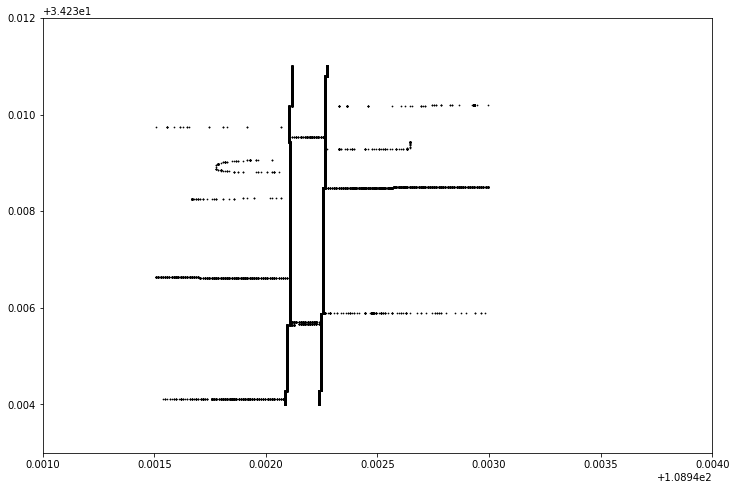

In [8]:
# crop the trips dataset and visualize the trips. If your implementation is correct you will see several parallel curves.
crop_trips_df_et = crop_region(trips_df_et, p1, p2, p3, p4)
plot_gps(crop_trips_df_et)

In [9]:
crop_trips_df_et.head()

,driver_id,order_id,time,lon,lat,lat_wgs,lon_wgs
0,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330804,108.94676,34.23590,34.237497,108.942107
1,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330846,108.94676,34.23491,34.236507,108.942107
2,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330783,108.94676,34.23736,34.238957,108.942107
3,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330843,108.94676,34.23515,34.236747,108.942107
4,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330786,108.94676,34.23711,34.238707,108.942107


### Task 1.4: Add Local Times

In [48]:
def add_local_time(crop_trips_df_et):
    crop_trips_df = crop_trips_df_et.copy()
    crop_trips_df = crop_trips_df.append({'driver_id' : 'test_bed', 
                                          'order_id' : 'test_bed',
                                          'time': 1458000000,
                                          'lon': 0.,
                                          'lat': 0.,
                                          'lon_wgs': 0.,
                                          'lat_wgs':0.} , ignore_index=True)
    """
    TODO:
    Input:
        crop_trips_df_et: the output from the function crop_region(), which should be a Pandas dataframe.
        
    Output:
        The output should also be a dataframe, but with ONE additional columns -- local time -- which converts 
        the epoch time (column "time") to Beijing Time (UTC+8)
    HINT:
        use Pandas pd.to_datetime() and pd.Timedelta() functions.
    """
    crop_trips_df['local_time']= pd.DatetimeIndex(pd.to_datetime(crop_trips_df['time'], unit='s'))\
                                .tz_localize('UTC').tz_convert('Asia/Shanghai')
    
    return crop_trips_df

In [49]:
final_crop_df = add_local_time(crop_trips_df_et)

In [50]:
# Run this block and attach the results to your writeups
print(final_crop_df.iloc[-1])

driver_id                      test_bed
order_id                       test_bed
time                         1458000000
lon                                   0
lat                                   0
lat_wgs                               0
lon_wgs                               0
local_time    2016-03-15 08:00:00+08:00
Name: 746, dtype: object
